In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import rankdata

In [2]:
def get_filenames(results_dir, precond = None):
    if precond is None:
        return os.listdir(results_dir), None
    else:
        names = []
        precond_list = []
        for type in precond:
            try:
                precond_names = os.listdir(os.path.join(results_dir, type))
            except FileNotFoundError: # If the preconditioner type is not present as a file (could occur due to divergence), skip it
                continue
            names.extend(precond_names)
            precond_list.extend(len(precond_names) * [type])
        return names, precond_list

In [3]:
# Gets the results for a given dataset + optimizer combination
def load_results(results_dir, dataset, opt, precond = None):
    results = {}
    results_dir = os.path.join(results_dir, dataset, opt)
    filenames, precond_list = get_filenames(results_dir, precond) # If preconditioner list is given, get filenames for the preconditioners in that order

    if opt in ['sgd', 'svrg', 'saga', 'lkatyusha', 'slbfgs']:
        for filename in filenames:
            if filename.endswith('.csv'):
                start = filename.find('_') + len('_')
                end = filename.find('_seed_')
                hyperparam = filename[start:end] # Get lr or L; we assume the hyperparameter only appears once across all files in the folder
                df = pd.read_csv(os.path.join(results_dir, filename))
                results[hyperparam] = df
    elif opt in ['sketchysgd', 'sketchysvrg', 'sketchysaga', 'sketchykatyusha']:
        for filename, preconditioner in zip(filenames, precond_list):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(results_dir, preconditioner, filename))
                results[preconditioner] = df # We assume the preconditioner only appears once across all files in the folder

    return results

In [4]:
# Loads minimum loss for a given dataset
def load_min_loss(results_dir, data, opt):
    min_loc_directory = os.path.join(results_dir, data, opt)
    filename = os.listdir(min_loc_directory)[0]
    df = pd.read_csv(os.path.join(min_loc_directory, filename))
    min_loss = df['train_loss'].values[0]
    return min_loss

In [5]:
# Compute the solve time (in epochs) for a given tolerance
# Dataframe is given by a dataset and optimizer combination
def solve_time(df, opt, min_loss, tol, time_units):
    train_loss = df['train_loss'].values
    train_loss_error = train_loss - min_loss
    occurences = np.where(train_loss_error < tol)
    if occurences[0].size == 0: # check for being empty
        return np.Inf
    else:
        good_epoch = occurences[0][0]
        if time_units == 'epochs':
            return good_epoch + 1 # Add 1 because epochs are 0-indexed
        elif time_units == 'full_gradients':
            # Adjust for the fact that SAGA and SketchySAGA take half as many full gradients as other methods per epoch
            if opt not in ['saga', 'sketchysaga', 'sgd', 'sketchysgd']:
                return (good_epoch + 1) * 2
            else:
                return good_epoch + 1
        elif time_units == 'seconds':
            cum_times = np.cumsum(df['times'].values)
            return cum_times[good_epoch]

In [6]:
# Singular dataset, multiple optimizers
# for logistic, min_opt is 'lbfgs'
# time_units is either 'epochs' or 'time'
def get_solve_times(results_dir, data, min_opt, opts, preconditioners, tol, time_units):
    min_loss = load_min_loss(results_dir, data, min_opt)

    solve_times = {}
    for opt in opts:
        if opt in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
            results = load_results(results_dir, data, opt)
            solve_times[opt] = np.Inf
            for param in results.keys():
                solve_times[opt] = np.minimum(solve_times[opt], solve_time(results[param], opt, min_loss, tol, time_units))
        elif opt in ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']:
            results = load_results(results_dir, data, opt, preconditioners)

            # Get elements in preconditioners that are not in results.keys() -- this can happen if the run diverged
            missing_precond = [precond for precond in preconditioners if precond not in results.keys()]

            for precond in results.keys():
                solve_times[(opt, precond)] = solve_time(results[precond], opt, min_loss, tol, time_units)
            for precond in missing_precond:
                solve_times[(opt, precond)] = np.Inf
    return solve_times

In [7]:
def get_sorted_params(results):
    params = list(results.keys())
    float_params = np.array([float(param) for param in params])
    order = np.argsort(float_params)
    sorted_params = [params[i] for i in order.tolist()]
    return sorted_params, float_params[order] # returns sorted params and sorted float params

In [8]:
# Get the best hyperparameter for a given dataset and optimizer combination
def get_best_hyperparam(results_dir, data, opt):
    results = load_results(results_dir, data, opt)
    sorted_params, sorted_float_params = get_sorted_params(results) # Sort to make sure the hyperparameters are in the correct order
    best_loss = np.Inf
    best_param_idx = None
    for i, param in enumerate(sorted_params):
        # Get the best attained loss during training and the corresponding index
        loss = np.nanmin(results[param]['train_loss'].values)
        if loss < best_loss:
            best_loss = loss
            best_param_idx = i
    return best_param_idx, sorted_float_params

In [9]:
def get_n_solved(solve_times, datasets, budget, time_units):
    opt_keys = list(solve_times[datasets[0]].keys())
    n_solved = {}
    for key in list(opt_keys):
        if time_units in ['epochs', 'full_gradients']:
            n_solved[key] = np.zeros(budget)
        elif time_units == 'seconds':
            # n_solved[key] = np.zeros(int(budget / 10))
            n_solved[key] = np.zeros(budget)

    # Loop through the datasets to check if we solved within the budget
    for dataset in solve_times.keys():
        for key in list(n_solved.keys()):
            time_to_solve = solve_times[dataset][key]
            if time_to_solve < budget:
                    n_solved[key][int(time_to_solve):] += 1

    return n_solved

In [10]:
def get_cum_ranks(sampling, budget, n_solved):
    sampling_idx = range(sampling - 1, budget, sampling)
    n_samples = len(sampling_idx)
    cum_ranks = dict.fromkeys(list(n_solved.keys()), 0)
    for idx in sampling_idx:
        n_solved_idx = []
        key_idx = []
        for key in list(n_solved.keys()):
            n_solved_idx.append(n_solved[key][idx]) # Get the number of problems solved at the given time for a given optimizer
            key_idx.append(key)
        n_solved_idx = np.array(n_solved_idx)
        ranking = n_solved_idx.shape[0] - rankdata(n_solved_idx, method='max') + 1 # Get the ranking of the number of problems solved
        for i, key in enumerate(key_idx):
            cum_ranks[key] += ranking[i]/n_samples # Average the ranking over the number of samples
            # print(str(int(ranking[i])) + '. ' + str(key) + ': ' + str(n_solved_idx[i]))
    cum_ranks = {k: v for k, v in sorted(cum_ranks.items(), key=lambda item: item[1])} # Sort the dictionary by the average ranking
    # print(cum_ranks)

    return cum_ranks

In [11]:
def get_xlabel(time_units):
    if time_units == 'epochs':
        return 'Epochs'
    elif time_units == 'full_gradients':
        return 'Full data passes'
    elif time_units == 'seconds':
        return 'Wall-clock time (s)'

In [12]:
def get_opt_precond_name(opt):
    if isinstance(opt, tuple):
        opt_name = opt[0]
        precond_name = opt[1]
    else:
        opt_name = opt
        precond_name = None
    
    return opt_name, precond_name

In [13]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name.startswith('sketchy'):
        linestyle = 'solid'
        marker = markers[precond_name]
        color = colors[opt_name]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'dashed'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]

    return linestyle, marker, color, label

In [14]:
def get_legend(results_keys, markers, colors, opt_plot_names, precond_plot_names):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in list(results_keys):
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
        legend_elements.append(Line2D([0], [0], color=color, label=label, linestyle = linestyle, marker = marker))
    return legend_elements

In [15]:
def format_plot(xlabel, axes):
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.tick_params(axis='both', which='minor', labelsize=10)
    axes.set_xlabel(xlabel, fontsize=14)

In [16]:
def save(directory, fig_name, fig):
    plt.figure(fig)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(os.path.join(directory, fig_name), bbox_inches='tight')

In [17]:
def performance_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors, markers):
    solve_times = {}
    for dataset in datasets:
        solve_times[dataset] = get_solve_times(results_dir, dataset, min_opt, opts, preconditioners, tol, time_units)

    n_solved = get_n_solved(solve_times, datasets, budget, time_units) # Get the number of datasets solved within the budget for each optimizer

    x_ticks = np.arange(budget) # +1 because we want to include the budget as a tick

    n_datasets = len(datasets)

    for key in list(n_solved.keys()):
        if not isinstance(key, tuple):
            plt.plot(x_ticks, n_solved[key]/n_datasets, label=opt_plot_names[key],
                      color=colors[key], linestyle='--', zorder=2)
        else:
            plt.plot(x_ticks, n_solved[key]/n_datasets, 
                    label=opt_plot_names[key[0]] + '-' + precond_plot_names[key[1]], 
                    color=colors[key[0]], marker = markers[key[1]], markevery=25, zorder=1)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.ylabel('Proportion of problems solved')
    plt.xlabel(get_xlabel(time_units))

    # # Make ranking bar plot
    # sampling = 10 # Get the ranking for every 10 time units
    # cum_ranks = get_cum_ranks(sampling, budget, n_solved)

    # # Plot the ranking bar plot
    # plt.figure(figsize=(12, 6))
    # for key in list(cum_ranks.keys()):
    #     if not isinstance(key, tuple):
    #         bar = plt.bar(opt_plot_names[key], cum_ranks[key], color=colors[key], width = 0.9)
    #     else:
    #         bar = plt.bar(opt_plot_names[key[0]] + '-' + precond_plot_names[key[1]], cum_ranks[key], color=colors[key[0]], width = 0.9)

    #     for rect in bar:
    #         plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), 
    #                         r'${}$'.format('%.2f' % cum_ranks[key]), fontsize = 10,
    #                         ha='center', va='bottom')        
    # plt.ylabel('Average ranking')
    # plt.xticks(rotation=45, ha="right")

In [18]:
def ranking_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors):
    solve_times = {}
    for dataset in datasets:
        solve_times[dataset] = get_solve_times(results_dir, dataset, min_opt, opts, preconditioners, tol, time_units)

    n_solved = get_n_solved(solve_times, datasets, budget, time_units) # Get the number of datasets solved within the budget for each optimizer

    # Make ranking bar plot
    sampling = 10 # Get the ranking for every 10 time units
    cum_ranks = get_cum_ranks(sampling, budget, n_solved)

    # Plot the ranking bar plot
    plt.figure(figsize=(12, 6))
    for key in list(cum_ranks.keys()):
        if not isinstance(key, tuple):
            bar = plt.bar(opt_plot_names[key], cum_ranks[key], color=colors[key], width = 0.9)
        else:
            bar = plt.bar(f'{opt_plot_names[key[0]]} ({precond_plot_names[key[1]]})', cum_ranks[key], color=colors[key[0]], width = 0.9)

        for rect in bar:
            plt.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), 
                            r'${}$'.format('%.2f' % cum_ranks[key]), fontsize = 10,
                            ha='center', va='bottom')        
    plt.ylabel('Average ranking')
    plt.xticks(rotation=45, ha="right")

In [19]:
def performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts, preconditioners,
                                          tol, time_units, budgets, opt_plot_names, precond_plot_names, colors,
                                            markers, identifier, save_dir):
    n_xaxes = len(time_units)
    fig, axes = plt.subplots(1, n_xaxes, figsize=(12, 6))

    for i, (time_unit, budget) in enumerate(zip(time_units, budgets)):
        solve_times = {}
        for dataset in datasets:
            solve_times[dataset] = get_solve_times(results_dir, dataset, min_opt, opts, preconditioners, tol, time_unit)

        n_solved = get_n_solved(solve_times, datasets, budget, time_unit) # Get the number of datasets solved within the budget for each optimizer

        x_ticks = np.arange(budget) # +1 because we want to include the budget as a tick

        n_datasets = len(datasets)

        if i == 0:
            legend_elements = get_legend(list(n_solved.keys()), markers, colors, opt_plot_names, precond_plot_names)
            
        for key in list(n_solved.keys()):
            if not isinstance(key, tuple):
                axes[i].plot(x_ticks, n_solved[key]/n_datasets, 
                label=opt_plot_names[key], color=colors[key], linestyle='--', zorder=2)
            else:
                axes[i].plot(x_ticks, n_solved[key]/n_datasets, 
                        label=opt_plot_names[key[0]] + '-' + precond_plot_names[key[1]], 
                        color=colors[key[0]], marker = markers[key[1]], markevery=25, zorder=1)
        format_plot(get_xlabel(time_unit), axes[i])

    fig.tight_layout(pad=2.0)
    fig.legend(handles = legend_elements, loc = 'upper center', 
            bbox_to_anchor = (0.5, 0.00), ncol=3, fontsize=14)
    fig.text(0, 0.5, 'Proportion of problems solved', va='center', rotation='vertical', fontsize=14)

    fig_name = f'{problem_type}_proportion_solved_combined_{identifier}.pdf'
    save(save_dir, fig_name, fig)

In [20]:
def ranking_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts, preconditioners, tol, time_units, budgets, opt_plot_names, precond_plot_names, colors, identifier, save_dir):
    n_xaxes = len(time_units)
    fig, axes = plt.subplots(1, n_xaxes, figsize=(12, 6))

    sampling = 10 # Get the ranking for every 10 time units

    for i, (time_unit, budget) in enumerate(zip(time_units, budgets)):
        solve_times = {}
        for dataset in datasets:
            solve_times[dataset] = get_solve_times(results_dir, dataset, min_opt, opts, preconditioners, tol, time_unit)

        n_solved = get_n_solved(solve_times, datasets, budget, time_unit) # Get the number of datasets solved within the budget for each optimizer
        cum_ranks = get_cum_ranks(sampling, budget, n_solved)
        for key in list(cum_ranks.keys()):
            if not isinstance(key, tuple):
                bar = axes[i].barh(opt_plot_names[key], cum_ranks[key], color=colors[key], height = 0.9)
            else:
                bar = axes[i].barh(f'{opt_plot_names[key[0]]} ({precond_plot_names[key[1]]})', cum_ranks[key], color=colors[key[0]], height = 0.9)
        format_plot('Average ranking', axes[i])
        axes[i].invert_yaxis()
        axes[i].set_title(get_xlabel(time_unit))

    fig.tight_layout(pad=2.0)
    fig.text(0, 0.5, 'Optimization method', va='center', rotation='vertical', fontsize=14)

    fig_name = f'{problem_type}_ranking_combined_{identifier}.pdf'
    save(save_dir, fig_name, fig)

In [21]:
def relative_time_comparison(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, opt_plot_names, precond_plot_names, colors):
    # Perform a relative time comparison
    solve_times = {}
    for dataset in datasets:
        solve_times = get_solve_times(results_dir, dataset, min_opt, opts, preconditioners, tol, time_units)

        smallest = min(solve_times.values())
        best_opt = min(solve_times, key=solve_times.get)
        # If none of the methods solved the problem, relative times are all infinity
        if smallest != np.inf:
            relative_times = {k: v/smallest for k, v in solve_times.items()}
        else:
            relative_times = {k: np.inf for k, v in solve_times.items()}

        plt.figure(figsize=(8, 4))
        for key in list(relative_times.keys()):
            # Give an outline to the bar corresponding to the best method
            if solve_times[key] == smallest:
                edgecolor = 'black'
                linewidth = 1.5
            else:
                edgecolor = None
                linewidth = 0

            # Hack to make everything show up on the plot
            if relative_times[key] == np.inf:
                to_plot = 0
                alpha = 0
            else:
                to_plot = relative_times[key]
                alpha = 1

            if isinstance(key, tuple):
                bar = plt.bar(opt_plot_names[key[0]] + '-' + precond_plot_names[key[1]], 
                        to_plot, color=colors[key[0]], width = 0.4,
                        linewidth = linewidth, edgecolor = edgecolor, alpha = alpha)

            else:
                bar = plt.bar(opt_plot_names[key], to_plot, color=colors[key], 
                        width = 0.4, linewidth = linewidth, edgecolor = edgecolor, alpha = alpha)
            
            for rect in bar:
                if relative_times[key] == np.inf:
                    plt.text(rect.get_x() + rect.get_width() / 2.0, 0, 
                                r'$\infty$', fontsize = 16,
                                ha='center', va='bottom')
                    
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Relative time to solution')
        plt.title(dataset)
        plt.gca().set_ylim(bottom = 0)

        # Make the label of the best bold
        # Get x ticks
        x_ticks = plt.gca().xaxis.get_major_ticks()
        for i, v in enumerate(solve_times.values()):
            if v == smallest and smallest != np.inf:
                x_ticks[i].label.set_fontweight('bold')

In [22]:
# For svrg, saga, lkatyusha, slbfgs only
def best_lr_plots(results_dir, datasets, opts_trunc, opt_plot_names):
    from decimal import Decimal

    # Plot the best learning rates for each method across datasets
    for opt in opts_trunc:
        sorted_params = get_best_hyperparam(results_dir, datasets[0], opt)[1]
        counts = np.zeros(len(sorted_params))
        for dataset in datasets:
            best_idx = get_best_hyperparam(results_dir, dataset, opt)[0]
            counts[best_idx] += 1

        # print(sorted_params)
        # print(counts)

        plt.figure()
        plt.bar(range(len(sorted_params)), counts)
        plt.title(opt_plot_names[opt])

        if opt != 'lkatyusha':
            plt.xlabel('Step size')
        else:
            plt.xlabel('L')

        sorted_params_strings = [f"{Decimal(str(x)):.2E}" for x in sorted_params]
        plt.xticks(range(len(sorted_params)), sorted_params_strings, rotation=45, ha="right")

In [23]:
colors = {
    'svrg': 'tab:blue', 
    'saga': 'tab:orange', 
    'lkatyusha': 'tab:pink',
    'slbfgs': 'tab:brown',
    'sketchysvrg': 'tab:blue',
    'sketchysaga': 'tab:orange',
    'sketchykatyusha': 'tab:pink'
}

markers = {
    'diagonal': 'o',
    'nystrom': '^',
    'sassn': 's',
    'lessn': 'd',
    'ssn': '*'
}

opt_plot_names = {
    'svrg': 'SVRG',
    'saga': 'SAGA',
    'lkatyusha': 'L-Katyusha',
    'slbfgs': 'SLBFGS',
    'sketchysvrg': 'SketchySVRG',
    'sketchysaga': 'SketchySAGA',
    'sketchykatyusha': 'SketchyKatyusha'
}

precond_plot_names = {
    'diagonal': 'DiagSSN',
    'nystrom': 'NySSN',
    'sassn': 'SASSN-C',
    'lessn': 'SASSN-R',
    'ssn': 'SSN'
}

In [24]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

# $\mu$ = 1e-2

In [25]:
results_dir = '../performance_results'

## Logistic

In [26]:
problem_type = 'logistic'
opts_main = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_main = ['nystrom', 'sassn', 'lessn', 'ssn']
opts_appdx = ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_appdx = ['diagonal', 'nystrom', 'sassn', 'lessn', 'ssn']
min_opt = 'lbfgs'
tol = 1e-4
datasets = [
    'a1a', 'a2a', 'a3a', 'a4a', 'a5a', 'a6a', 'a7a', 'a8a', 'a9a',
    'covtype', 'epsilon', 'german.numer', 'gisette',
    'higgs', 'ijcnn1', 'madelon', 'mushrooms', 'news20', 'phishing',
    'rcv1', 'real-sim', 'splice', 'sonar', 'susy', 'svmguide3',
    'w1a', 'w2a', 'w3a', 'w4a', 'w5a', 'w6a', 'w7a', 'w8a', 'webspam'
]
time_units_list = ['seconds', 'full_gradients']
save_dir = './performance'

In [27]:
# time_units = 'seconds'
# budget = 600

# performance_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors, markers)
# ranking_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors)

In [28]:
# time_units = 'full_gradients'
# budget = 200

# performance_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors, markers)
# ranking_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors)

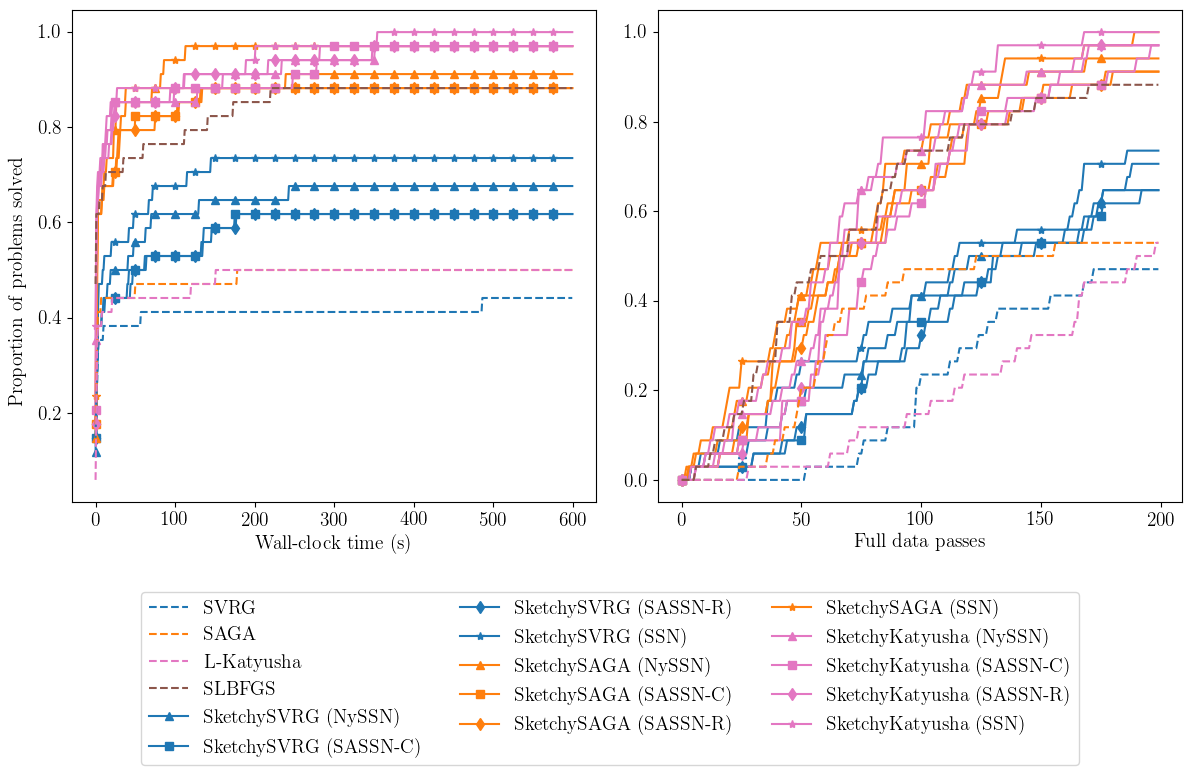

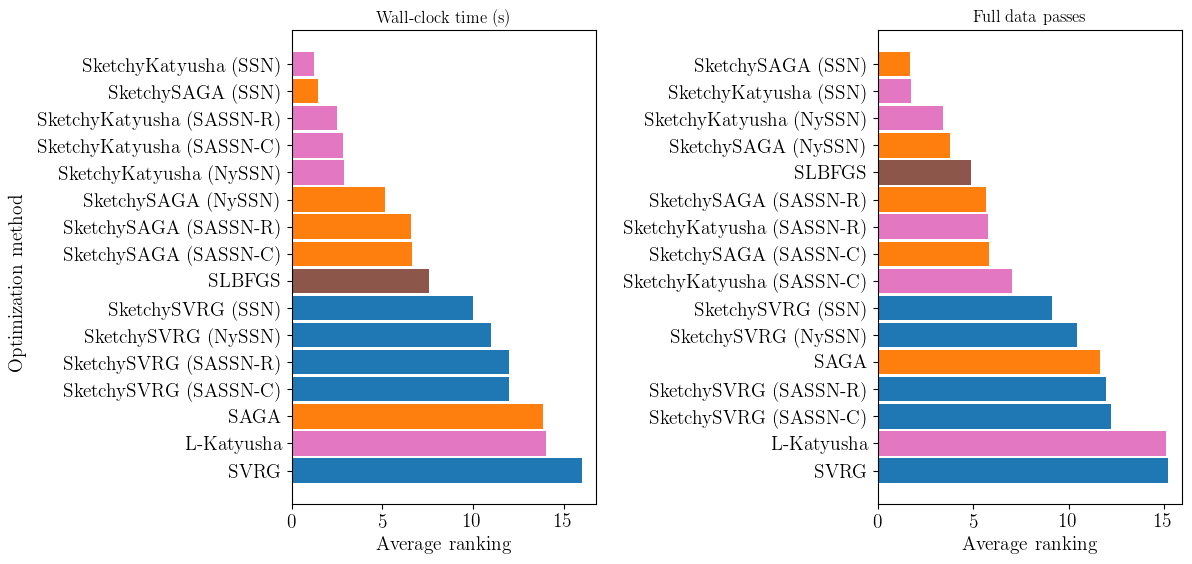

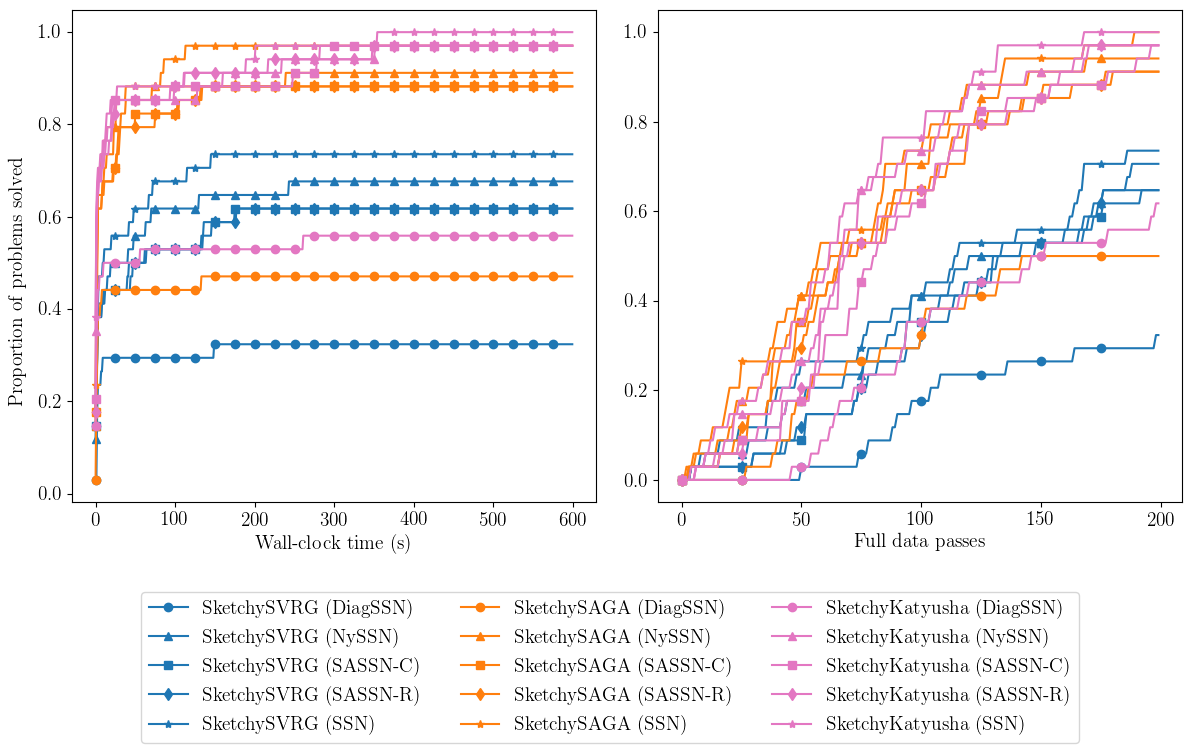

In [29]:
budgets_list = [600, 200]

performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'main', save_dir)
ranking_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, 'main', save_dir)
performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_appdx, preconditioners_appdx, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'appdx', save_dir)

In [30]:
# relative_time_comparison(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units_list[0], opt_plot_names, precond_plot_names, colors)

In [31]:
# best_lr_plots(results_dir, datasets, ['svrg', 'saga', 'lkatyusha', 'slbfgs'], opt_plot_names)

## Logistic (sparse)

In [32]:
datasets_sparse = ['a1a', 'a2a', 'a3a', 'a4a', 'a5a', 'a6a',
                    'a7a', 'a8a', 'a9a', 'mushrooms', 'news20',
                      'rcv1', 'real-sim', 'w1a', 'w2a', 'w3a', 'w4a',
                        'w5a', 'w6a', 'w7a', 'w8a']

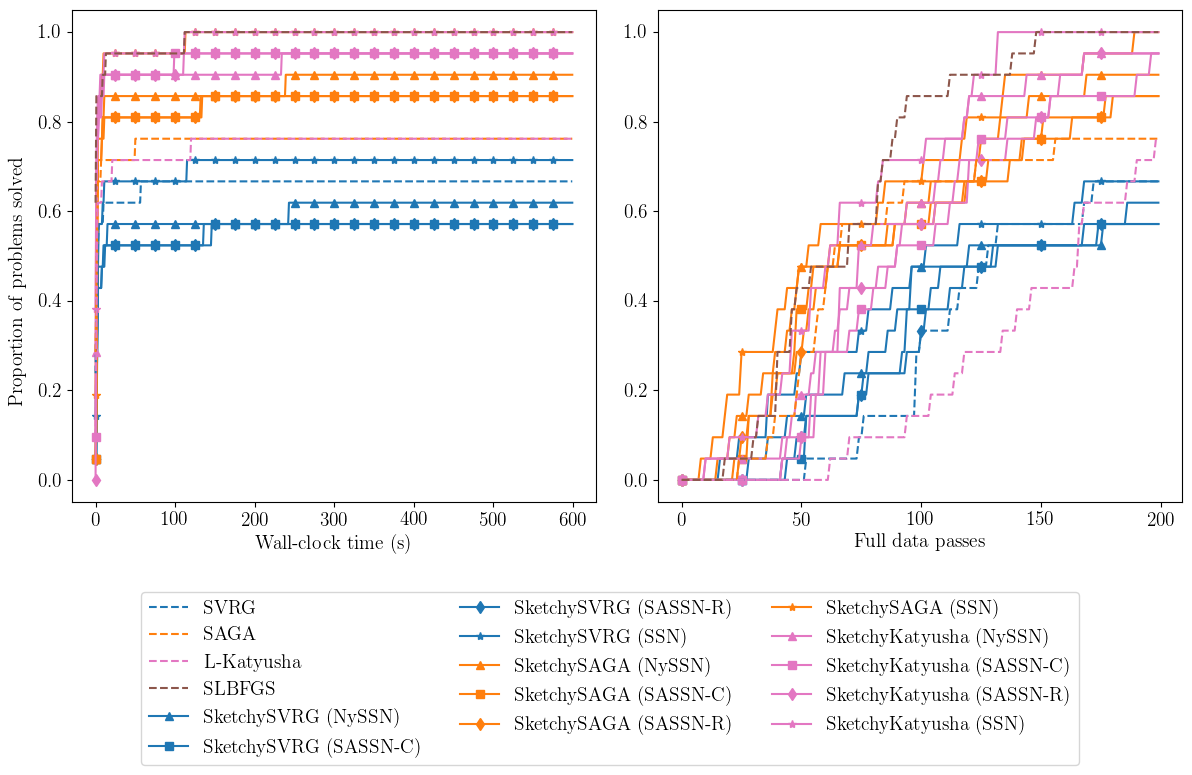

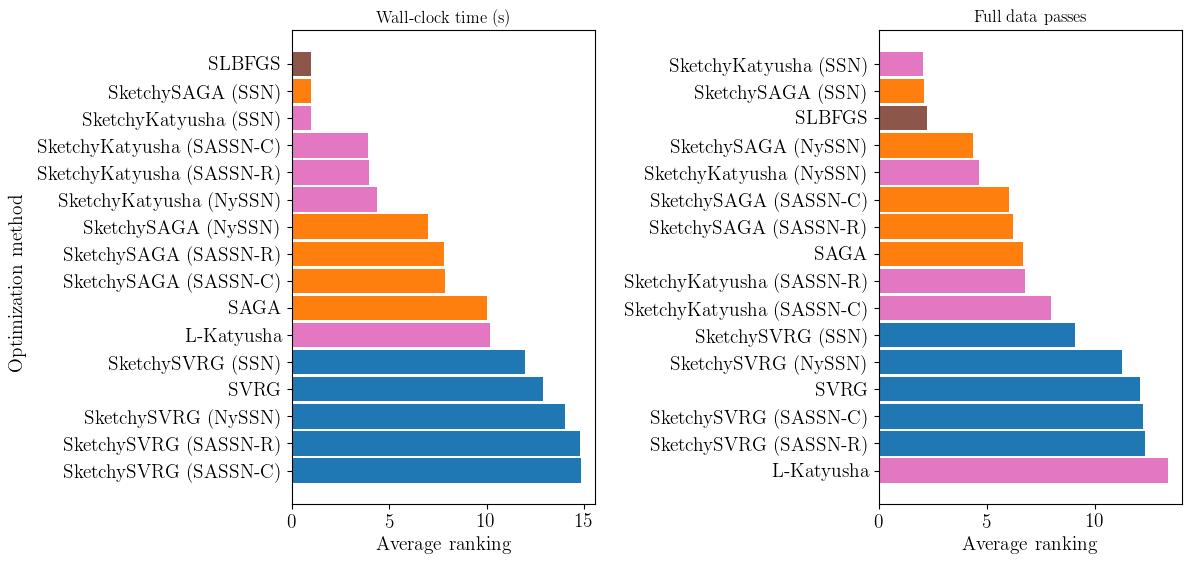

In [33]:
budgets_list = [600, 200]

performance_plot_multiple_time_units(results_dir, problem_type, datasets_sparse, min_opt, opts_main, preconditioners_main, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'appdx_sparse', save_dir)
ranking_plot_multiple_time_units(results_dir, problem_type, datasets_sparse, min_opt, opts_main, preconditioners_main, tol,
                                time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, 'appdx_sparse', save_dir)

## Logistic (dense)

In [34]:
datasets_dense = ['covtype', 'epsilon', 'german.numer', 'gisette',
 'higgs', 'ijcnn1', 'madelon', 'phishing', 'splice',
   'sonar', 'susy', 'svmguide3', 'webspam']

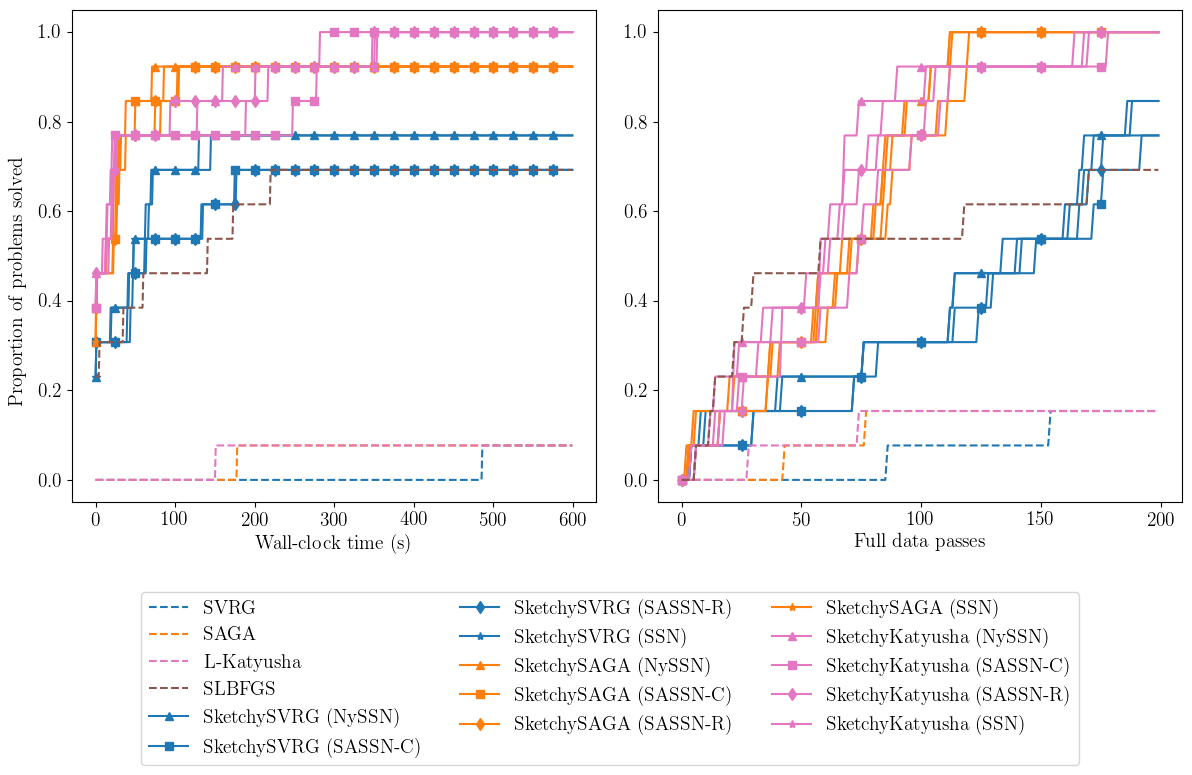

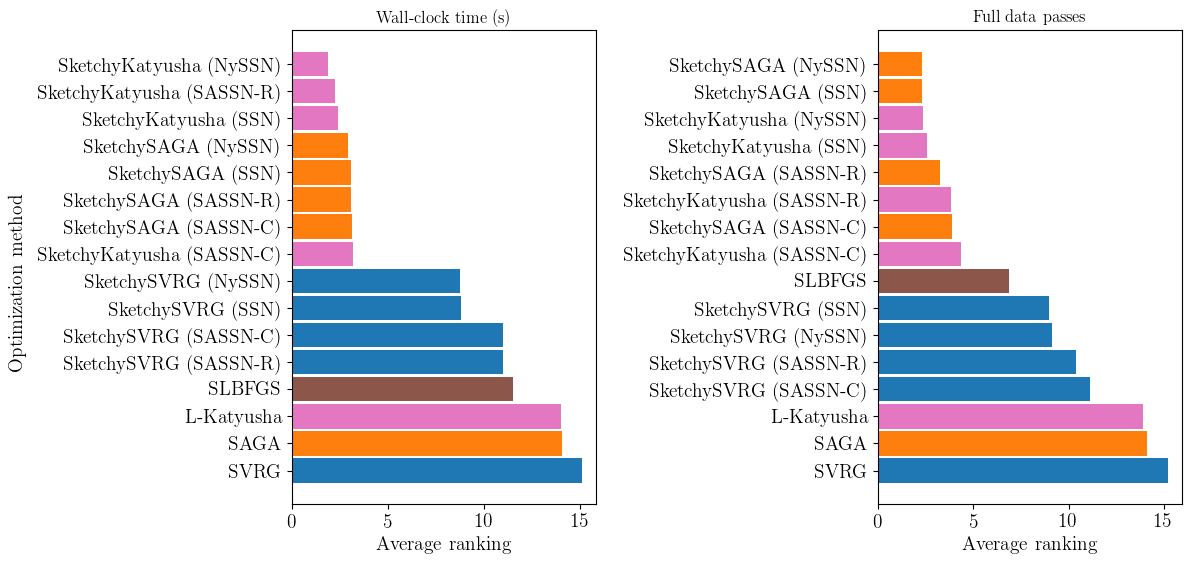

In [35]:
budgets_list = [600, 200]

performance_plot_multiple_time_units(results_dir, problem_type, datasets_dense, min_opt, opts_main, preconditioners_main, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'appdx_dense', save_dir)
ranking_plot_multiple_time_units(results_dir, problem_type, datasets_dense, min_opt, opts_main, preconditioners_main, tol,
                                time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, 'appdx_dense', save_dir)

## Least squares

In [36]:
problem_type = 'least_squares'
opts_main = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_main = ['nystrom', 'sassn', 'lessn', 'ssn']
opts_appdx = ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_appdx = ['diagonal', 'nystrom', 'sassn', 'lessn', 'ssn']
min_opt = 'lsqr'
tol = 1e-4
datasets = [
    'e2006', 'yearpredictionmsd', 'santander', 
    'jannis', 'yolanda', 'miniboone', 'guillermo',
    'creditcard', 'acsincome', 'medical', 'airlines',
    'click-prediction', 'mtp', 'elevators', 'ailerons',
    'superconduct', 'sarcos'
]
time_units_list = ['seconds', 'full_gradients']
save_dir = './performance'

In [37]:
# time_units = 'seconds'
# budget = 600

# performance_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors, markers)
# ranking_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors)

In [38]:
# time_units = 'full_gradients'
# budget = 200

# performance_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors, markers)
# ranking_plot(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units, budget, opt_plot_names, precond_plot_names, colors)

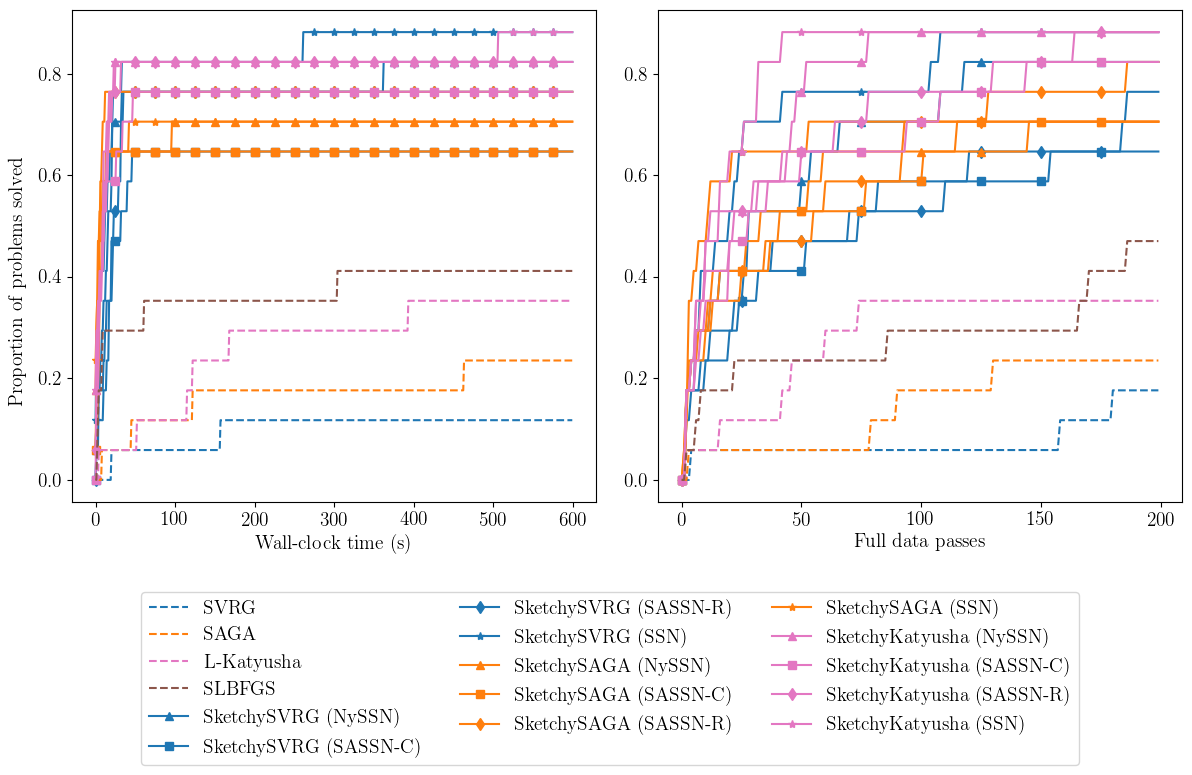

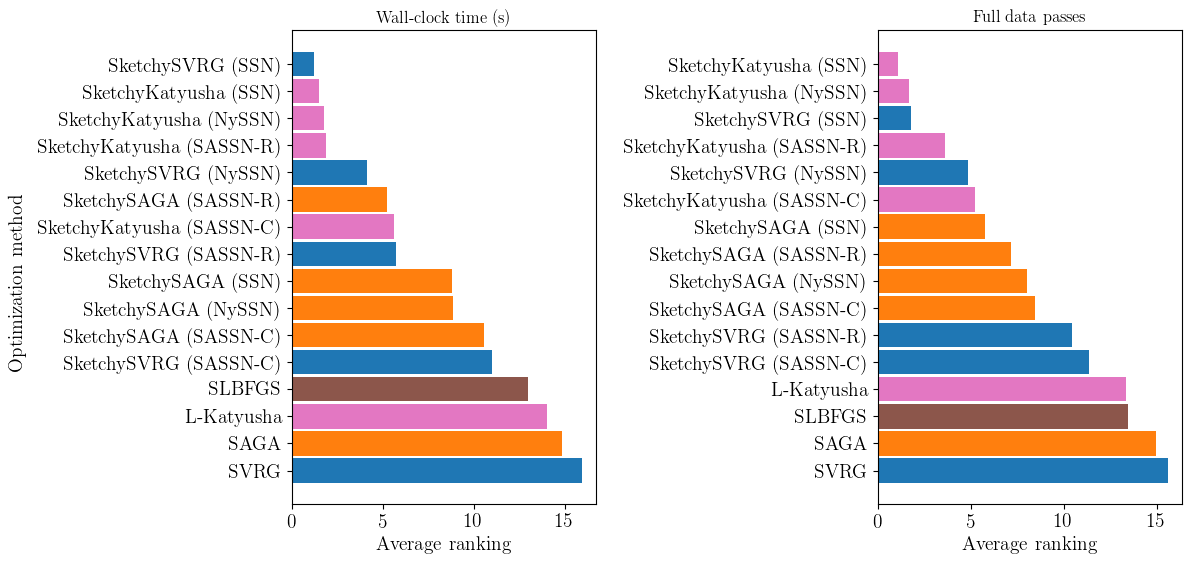

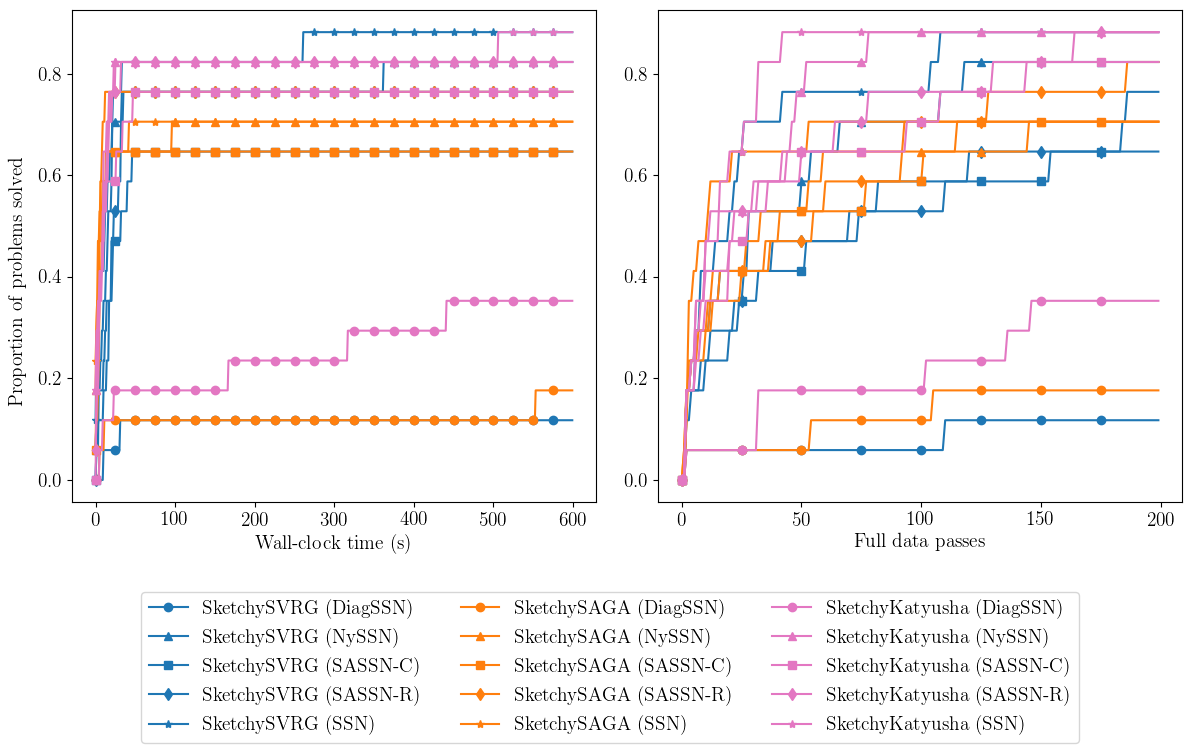

In [39]:
budgets_list = [600, 200]

performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'main', save_dir)
ranking_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, 'main', save_dir)
performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_appdx, preconditioners_appdx, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'appdx', save_dir)

In [40]:
# relative_time_comparison(results_dir, datasets, min_opt, opts, preconditioners, tol, time_units_list[0], opt_plot_names, precond_plot_names, colors)

In [41]:
# best_lr_plots(results_dir, datasets, ['svrg', 'saga', 'lkatyusha', 'slbfgs'], opt_plot_names)

# $\mu$ = 1e-1

In [42]:
results_dir = '../performance_results_mu_1e-1'

## Logistic

In [43]:
problem_type = 'logistic'
opts_main = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_main = ['nystrom', 'sassn', 'lessn', 'ssn']
opts_appdx = ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_appdx = ['diagonal', 'nystrom', 'sassn', 'lessn', 'ssn']
min_opt = 'lbfgs'
tol = 1e-4
datasets = [
    'a1a', 'a2a', 'a3a', 'a4a', 'a5a', 'a6a', 'a7a', 'a8a', 'a9a',
    'covtype', 'epsilon', 'german.numer', 'gisette',
    'higgs', 'ijcnn1', 'madelon', 'mushrooms', 'news20', 'phishing',
    'rcv1', 'real-sim', 'splice', 'sonar', 'susy', 'svmguide3',
    'w1a', 'w2a', 'w3a', 'w4a', 'w5a', 'w6a', 'w7a', 'w8a', 'webspam'
]

time_units_list = ['seconds', 'full_gradients']
save_dir = './performance'

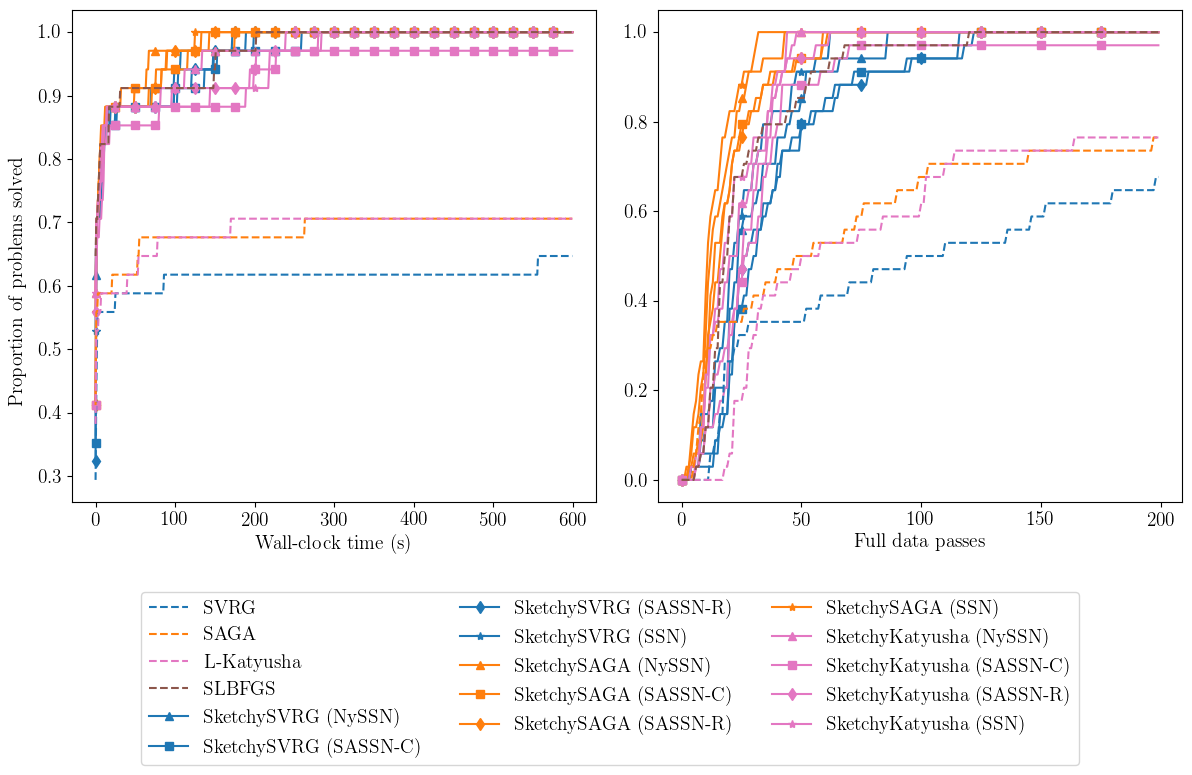

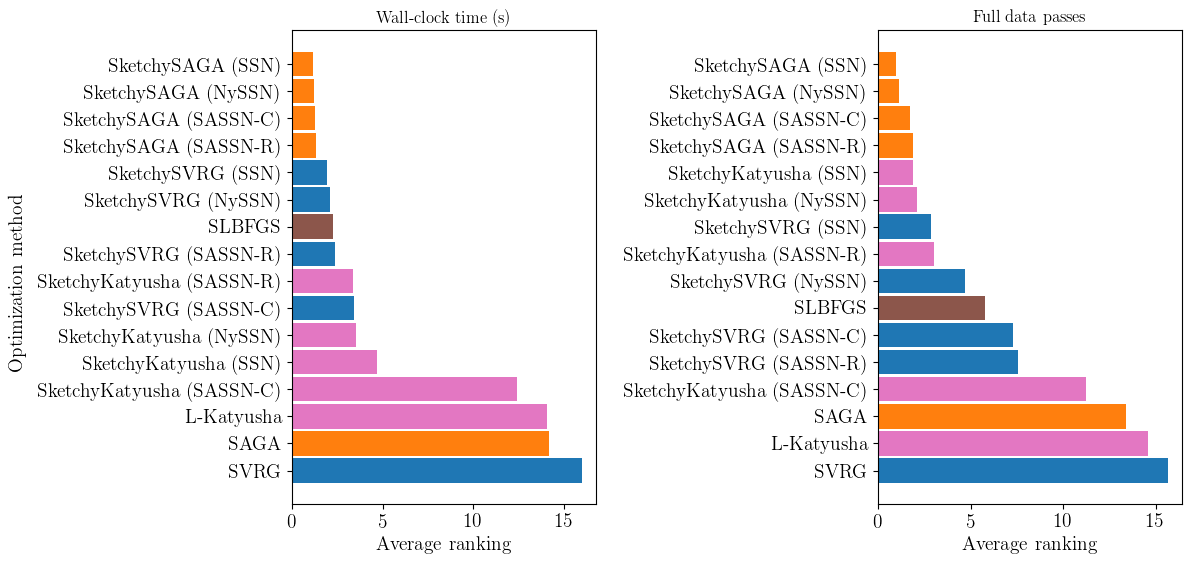

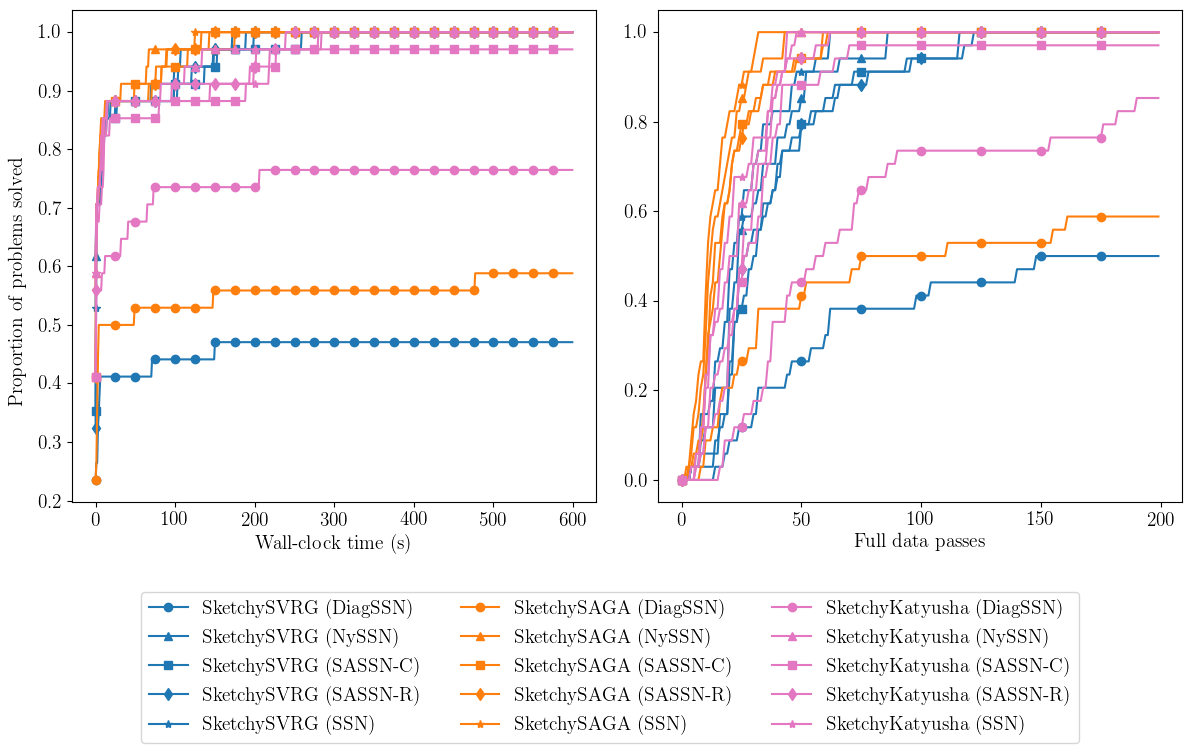

In [44]:
budgets_list = [600, 200]

performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'main_mu_1e-1', save_dir)
ranking_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, 'main_mu_1e-1', save_dir)
performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_appdx, preconditioners_appdx, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'appdx_mu_1e-1', save_dir)

## Least squares

In [45]:
problem_type = 'least_squares'
opts_main = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_main = ['nystrom', 'sassn', 'lessn', 'ssn']
opts_appdx = ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']
preconditioners_appdx = ['diagonal', 'nystrom', 'sassn', 'lessn', 'ssn']
min_opt = 'lsqr'
tol = 1e-4
datasets = [
    'e2006', 'yearpredictionmsd', 'santander', 
    'jannis', 'yolanda', 'miniboone', 'guillermo',
    'creditcard', 'acsincome', 'medical', 'airlines',
    'click-prediction', 'mtp', 'elevators', 'ailerons',
    'superconduct', 'sarcos'
]
time_units_list = ['seconds', 'full_gradients']
save_dir = './performance'

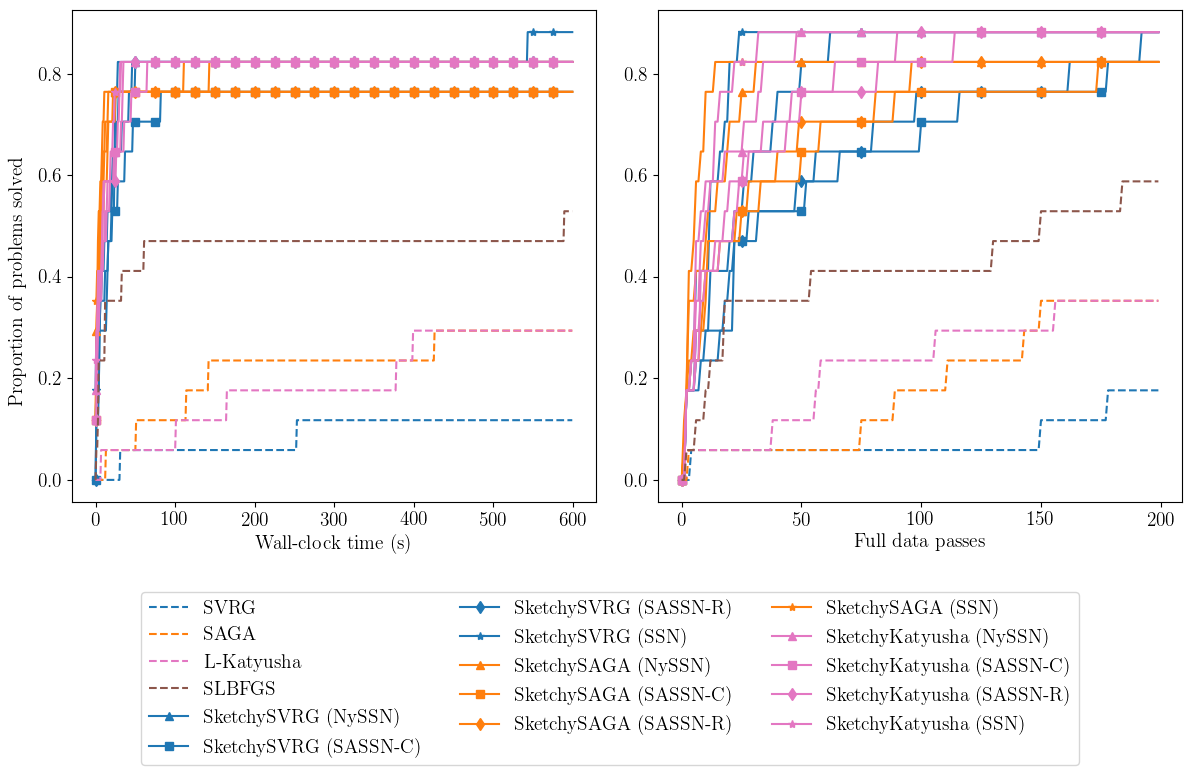

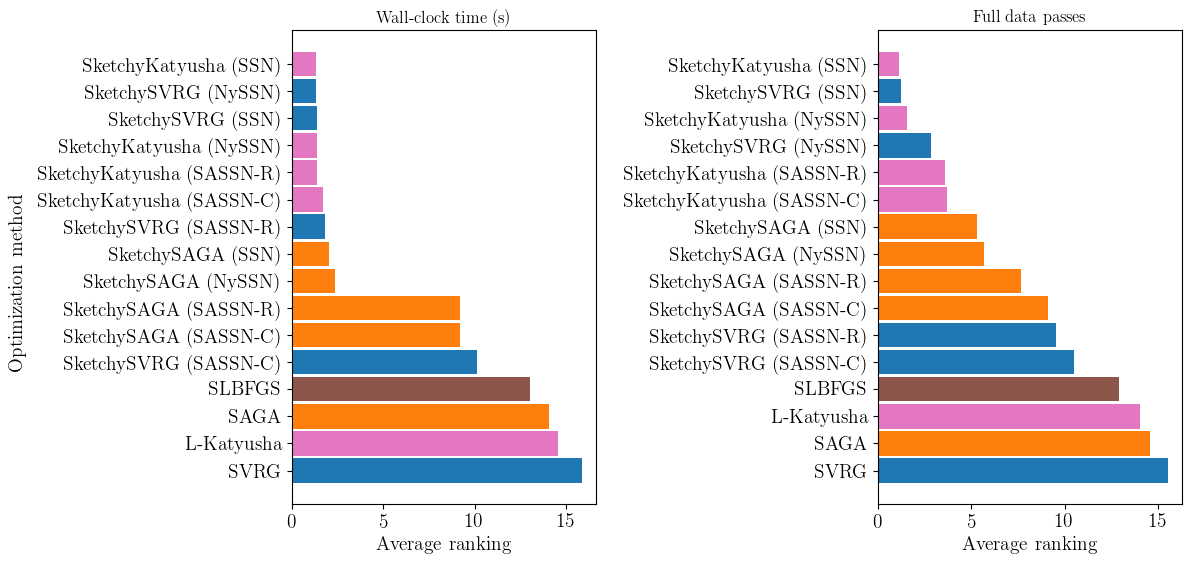

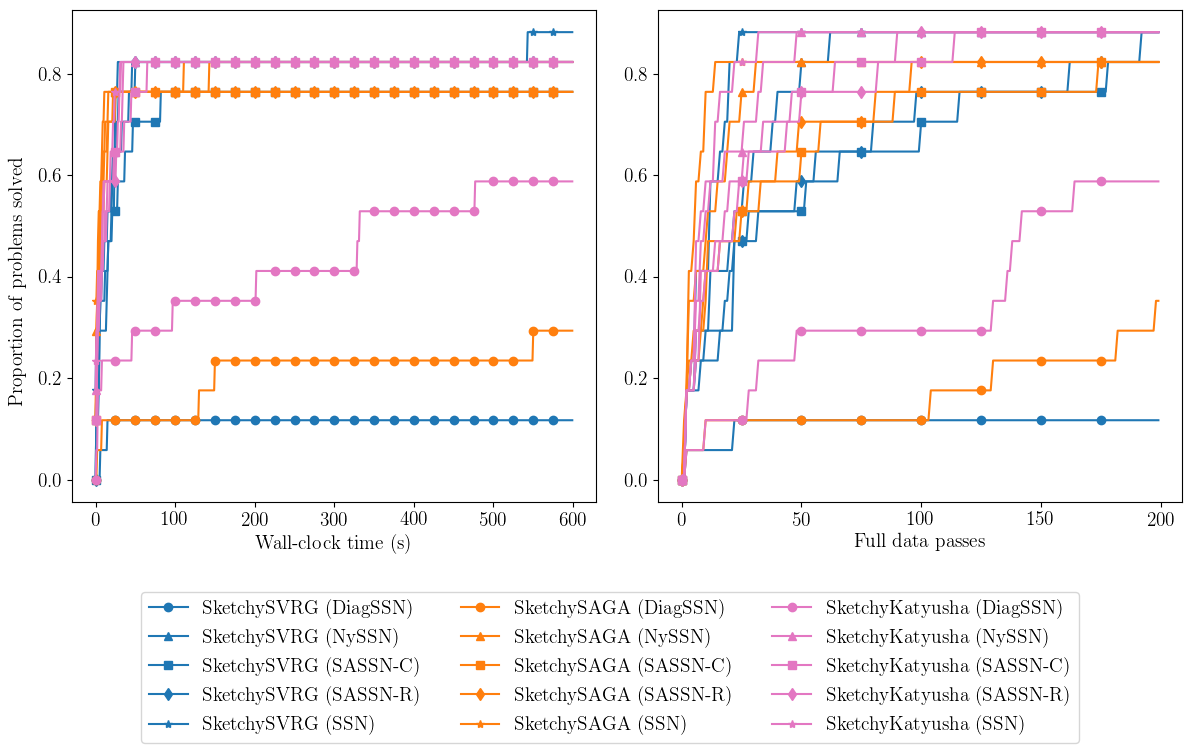

In [46]:
budgets_list = [600, 200]

performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'main_mu_1e-1', save_dir)
ranking_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_main, preconditioners_main, tol,
                                time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, 'main_mu_1e-1', save_dir)
performance_plot_multiple_time_units(results_dir, problem_type, datasets, min_opt, opts_appdx, preconditioners_appdx, tol,
                                    time_units_list, budgets_list, opt_plot_names, precond_plot_names, colors, markers, 'appdx_mu_1e-1', save_dir)